<a href="https://colab.research.google.com/github/NisalDaksith/AND-OR-NOT/blob/main/Humidity_Predictor_Arima_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00


In [ ]:
#Importing all the necessary Libraries
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import pickle
from numpy import log 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_predict   
import itertools

In [ ]:
df = pd.read_csv('colombo_rh_2012-2018.csv')
df

,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
4398,43466,COLOMBO,RHMAX,2018,12,27,90.0
4399,43466,COLOMBO,RHMAX,2018,12,28,88.0
4400,43466,COLOMBO,RHMAX,2018,12,29,76.0
4401,43466,COLOMBO,RHMAX,2018,12,30,81.0


In [ ]:
#Dropping RHMIN as it can confuse the model
df = df.drop(df[df['element_name'] == 'RHMIN'].index)
df

,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
4398,43466,COLOMBO,RHMAX,2018,12,27,90.0
4399,43466,COLOMBO,RHMAX,2018,12,28,88.0
4400,43466,COLOMBO,RHMAX,2018,12,29,76.0
4401,43466,COLOMBO,RHMAX,2018,12,30,81.0


In [ ]:
#redefining the df
df = df[['year','month','day','obs_val']]
df

,year,month,day,obs_val
0,2012,1,1,91.0
1,2012,1,2,90.0
2,2012,1,3,89.0
3,2012,1,4,89.0
4,2012,1,5,95.0
...,...,...,...,...
4398,2018,12,27,90.0
4399,2018,12,28,88.0
4400,2018,12,29,76.0
4401,2018,12,30,81.0


In [ ]:
#Dropping Null Values
df = df.dropna()
df.isna().sum()

year       0
month      0
day        0
obs_val    0
dtype: int64

In [ ]:
#Dropping Duplicates
print(df.duplicated().sum())
df = df.drop_duplicates()
df.shape

365


(2557, 4)

In [ ]:
df.head(20)

,year,month,day,obs_val
0,2012,1,1,91.0
1,2012,1,2,90.0
2,2012,1,3,89.0
3,2012,1,4,89.0
4,2012,1,5,95.0
5,2012,1,6,93.0
6,2012,1,7,96.0
7,2012,1,8,96.0
8,2012,1,9,98.0
9,2012,1,10,93.0


In [ ]:
#Creating the "Date" Column
cols=["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [ ]:
#Removing invalid Date Values
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df

,year,month,day,obs_val,date
0,2012,1,1,91.0,2012-01-01
1,2012,1,2,90.0,2012-01-02
2,2012,1,3,89.0,2012-01-03
3,2012,1,4,89.0,2012-01-04
4,2012,1,5,95.0,2012-01-05
...,...,...,...,...,...
2937,2018,12,27,90.0,2018-12-27
2938,2018,12,28,88.0,2018-12-28
2939,2018,12,29,76.0,2018-12-29
2940,2018,12,30,81.0,2018-12-30


In [ ]:
#Dropping Year, Month, Day columns
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
df.drop(['year', 'month', 'day'], axis=1,inplace=True)
df

,obs_val,date
0,91.0,2012-01-01
1,90.0,2012-01-02
2,89.0,2012-01-03
3,89.0,2012-01-04
4,95.0,2012-01-05
...,...,...
2937,90.0,2018-12-27
2938,88.0,2018-12-28
2939,76.0,2018-12-29
2940,81.0,2018-12-30


In [ ]:
#Setting "date" as the index
df = df.set_index('date')

In [ ]:
df

,obs_val
date,
2012-01-01,91.0
2012-01-02,90.0
2012-01-03,89.0
2012-01-04,89.0
2012-01-05,95.0
...,...
2018-12-27,90.0
2018-12-28,88.0
2018-12-29,76.0


<Axes: xlabel='date'>

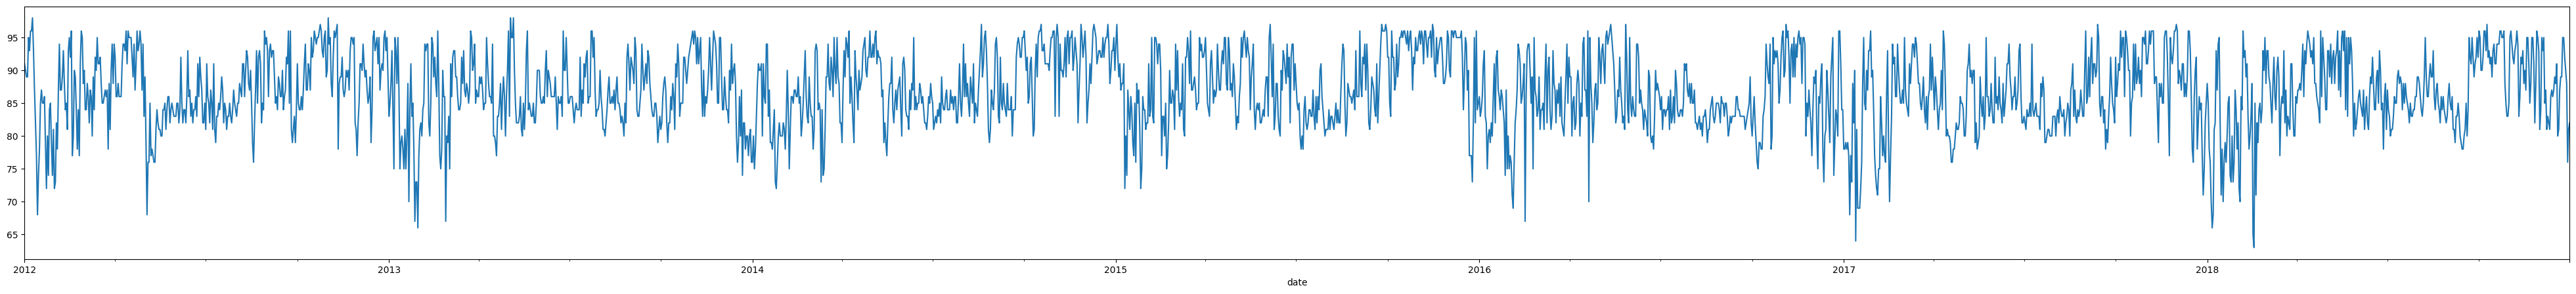

In [ ]:
#Plotting Observed values
df['obs_val'].plot(figsize=(50,5))

In [ ]:
#Augmented Dickey Fuller (For Checking Stationarity)
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(df['obs_val'])

1. ADF :  -7.951975596559477
2. P-Value :  3.1084526115137386e-12
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 2540
5. Critical Values :
	 1% :  -3.4329271342415577
	 5% :  -2.8626785721005303
	 10% :  -2.5673761046872094


In [ ]:
stepwise_search = auto_arima(df['obs_val'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14873.008, Time=3.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16163.865, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14928.154, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15376.137, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30098.217, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14865.027, Time=4.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15094.561, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14870.516, Time=4.76 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=14853.432, Time=10.66 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=15002.144, Time=3.39 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=14858.688, Time=8.11 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=14847.986, Time=14.26 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=14948.370, Time=3.11 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=14851.368, Time=8.86 sec
 ARIMA(1,0,5)(0,0

The auto_arima function is part of the pmdarima package, which provides an implementation of the ARIMA algorithm.
This function automatically selects the optimal parameters for the ARIMA model using a stepwise approach. 
It fits multiple ARIMA models with different parameters and selects the best one based on the AIC value.

In [ ]:
#Train Test Split (Doesnt use traditional test train split)
train=df.iloc[:-100]
test=df.iloc[-100:]
print(train.shape,test.shape)

(2457, 1) (100, 1)


In [ ]:
# #First Trained Model
# from statsmodels.tsa.arima.model import ARIMA
# model=ARIMA(train['obs_val'],order=(1,0,4))
# model=model.fit()
# model.summary()

Since the p- value is less than 0.05 the null hypothesis can be rejected so, at a siginificant level of 95% we can say that the time series is stationary. so, with that d value can be taken as 0.

In [ ]:
# #Checking the Outputs from first model (Not working Properly)
# start=len(train)
# end=len(train)+len(test)-1
# pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
# pred.plot(legend=True)
# test['obs_val'].plot(legend=True)

In [ ]:
# #Predictions from the first model (Nearly Useless)
# predictions = model.predict('2013-10-01','2014-10-01').rename('Forward Predictions')
# predictions

In [ ]:
# model = ARIMA(df.obs_val, order=(2,1,2))  
# results_MA = model.fit()  
# plt.plot(df.obs_val)
# plt.plot(results_MA.fittedvalues, color='red')
# plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df.obs_val)**2).mean()))
# plt.show()

In [ ]:
res = adfuller(df.obs_val.dropna())  
print('Augmented Dickey-Fuller Statistic: %f' % res[0])  
print('p-value: %f' % res[1])  

Augmented Dickey-Fuller Statistic: -7.951976
p-value: 0.000000


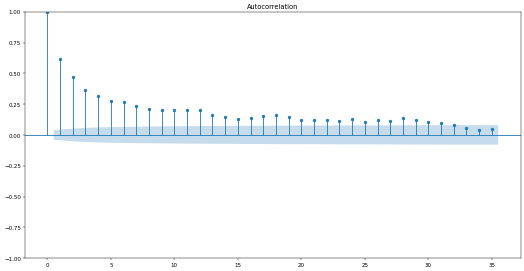

In [ ]:
plt.rcParams.update({'figure.figsize' : (16,8), 'figure.dpi' : 40})
plot_acf(df.obs_val.dropna())  
      
plt.show() 

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


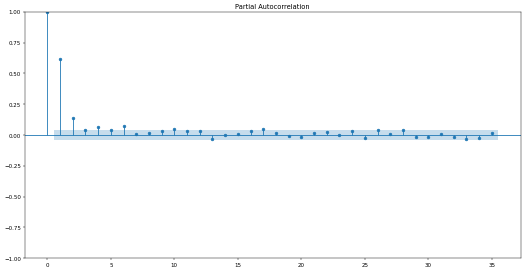

In [ ]:
plt.rcParams.update({'figure.figsize' : (16,8), 'figure.dpi' : 40})
plot_pacf(df.obs_val.dropna())  
      
plt.show() 

In [ ]:
#Training the second model
model = sm.tsa.arima.ARIMA(df.obs_val, order=(2,1,3))
model2 = model.fit()
print(model2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                obs_val   No. Observations:                 2557
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -7426.750
Date:                Sun, 07 May 2023   AIC                          14865.499
Time:                        13:40:58   BIC                          14900.576
Sample:                    01-01-2012   HQIC                         14878.219
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.041     -8.337      0.000      -0.422      -0.262
ar.L2          0.6118      0.039     15.790      0.000       0.536       0.688
ma.L1         -0.1327      0.046     -2.912      0.0

<Axes: xlabel='date'>

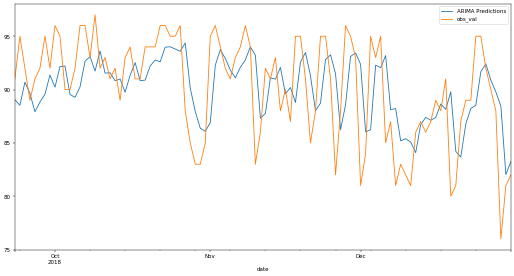

In [ ]:
#Testing the second model
start=len(train)
end=len(train)+len(test)-1
pred=model2.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['obs_val'].plot(legend=True)

<Axes: >

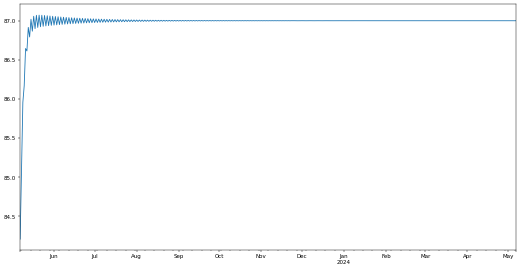

In [ ]:
start_date = '2023-05-07'
end_date = '2024-05-07'
date_range = pd.date_range(start=start_date, end=end_date)
predictions_future = model2.forecast(steps=len(date_range))
predictions_future.index = date_range
predictions_future
#Save the forecast DataFrame as a CSV file
pd.DataFrame(predictions_future).reset_index().to_csv('future_forecast.csv', index=False)
predictions_future.plot()

<Axes: >

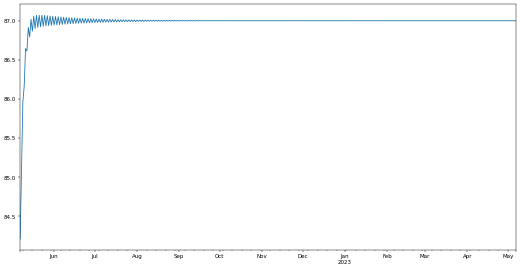

In [ ]:
start_date = '2022-05-07'
end_date = '2023-05-07'
date_range = pd.date_range(start=start_date, end=end_date)
predictions_past = model2.forecast(steps=len(date_range))
predictions_past.index = date_range
predictions_past
#Save the forecast DataFrame as a CSV file
pd.DataFrame(predictions_past).reset_index().to_csv('past_forecast.csv', index=False)
predictions_past.plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


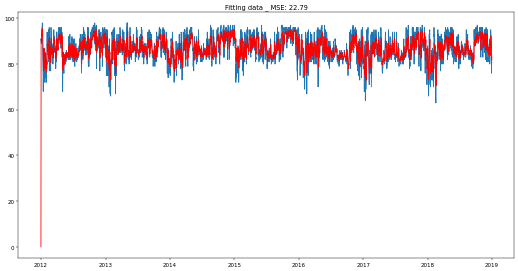

In [ ]:
model2 = ARIMA(df.obs_val, order=(2,1,3))  
results_MA = model2.fit()  
plt.plot(df.obs_val)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df.obs_val)**2).mean()))
plt.show()

In [ ]:

# Save the model to a file
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model2, f)


In [ ]:

# Load the model from a file
with open('arima_model.pkl', 'rb') as f:
    model2 = pickle.load(f)